In [1]:
from ase.build import bulk
#Creation of an Al structure
a = 4.08521896  # lattice parameter in Angstrom
aluminum = bulk(name="Al", crystalstructure="fcc", a=a)

# job.sh file

<pre>
#!/bin/bash -l
#SBATCH --job-name=QE_Aluminum
#SBATCH --ntasks=32
#SBATCH --nodes=1
#SBATCH --time=01:00:00
#SBATCH --partition=workstation
#SBATCH --output=%j_qe_job.out
#SBATCH --error=%j_qe_job.err
#SBATCH --cpus-per-task=1

# Activate conda environment
source /home/da36nik/miniconda3/etc/profile.d/conda.sh
conda activate MI_08

# Disable OpenMP to avoid MPI conflicts
export OMP_NUM_THREADS=1

# Set up scratch directory
ODIR=$SLURM_SUBMIT_DIR
TMPDIR=$(mktemp -d /scratch/tmp.$USER.XXXXXXX)

# Copy input and pseudopotential files to scratch
mkdir -p $TMPDIR/pseudo
cp calc.pwi $TMPDIR/
cp Al.pbe-n-kjpaw_psl.1.0.0.UPF $TMPDIR/pseudo/
cd $TMPDIR

# Run Quantum ESPRESSO
mpirun.openmpi -np $SLURM_NTASKS pw.x -i calc.pwi >scf.out
# Copy results back
cp *.out *.xml $ODIR/

# Clean up
cd $ODIR
rm -rf $TMPDIR

# Deactivate conda
conda deactivate
<pre>

In [ ]:
from ase.io.espresso import write_espresso_in
import os

kpts_list = [(4,4,4), (6,6,6), (7,7,7)]
ecutwfc_list = [30, 40, 50]

#create directories for with an input file
for kpts in kpts_list:
    for ecutwfc in ecutwfc_list:
        # Prepare input_data for this run
        input_data = {
            'calculation': 'vc-relax',
            'pseudo_dir': 'pseudo',
            'occupations': 'smearing',
            'degauss': 0.02,
            'ecutwfc': ecutwfc,
            'forc_conv_thr': 1.0E-08
        }
        # Make a directory for this run
        dirname = f"k{kpts[0]}_ecut{ecutwfc}"
        os.makedirs(dirname, exist_ok=True)
        # Write the input file
        input_path = os.path.join(dirname, "calc.pwi")
        write_espresso_in(
            input_path,
            aluminum,
            input_data=input_data,
            kpts=kpts,
            pseudopotentials={'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}
        )



After creating the input files in the respective directories I copied the .UPF file and the job.sh file into each directory. Then I cd'd into the directory and from there tried to submit the job with "sbatch job.sh".

I was unable to resolve the error that the .UPF file could not be found. Before I had issues with the mpirun from this line:
<pre>
mpirun.openmpi -np $SLURM_NTASKS pw.x -i calc.pwi >scf.out
</pre>

I tested this in the terminal:
<pre>
which pw.x
/home/da36nik/miniconda3/envs/MI_08/bin/pw.x

which mpirun
/usr/bin/mpirun
</pre>

Equilibrium volume: 16.5661 Å³
Minimum energy: -537.535288 eV
Bulk modulus: 0.48 GPa
Bulk modulus: 77.56 GPa 


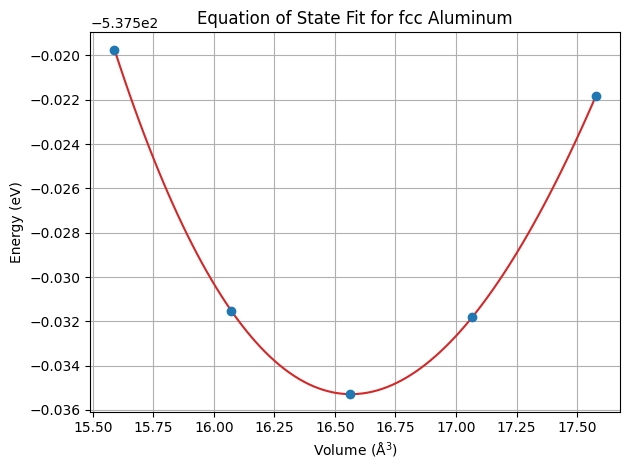

In [ ]:
from ase.eos import EquationOfState
import numpy as np
import matplotlib.pyplot as plt
from ase.units import kJ

energy_volume_dict = {
    15.589747612402249: -537.51973580881259,
    16.071870012167288: -537.5315154801444,
    16.563831284263994: -537.535293137697,
    17.06573081101837:  -537.5318243293514,
    17.577667974756416: -537.5218284996022
}

# Prepare data
volumes = np.array(list(energy_volume_dict.keys()))
energies = np.array(list(energy_volume_dict.values()))

# Fit EOS
eos = EquationOfState(volumes, energies, eos="murnaghan")
v0, e0, B = eos.fit() # B is the bulk modulus in the units eV/Angstrom^3

print(f"Equilibrium volume: {v0:.4f} Å³")
print(f"Minimum energy: {e0:.6f} eV")
print(f"Bulk modulus: {(B / kJ * 1.0e24):.2f} GPa ") #convert the bulk modulus into GPa
# Plot the EOS fit
fig = eos.plot(show=False)
plt.title("Equation of State Fit for fcc Aluminum")
plt.xlabel("Volume ($\mathrm{\AA}^3$)")
plt.ylabel("Energy (eV)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
from mp_api.client import MPRester

api_key = "7UWykGWbVgCdp8QA7JEi5xMQ7kGSqKS9" #my API key
with MPRester(api_key) as mpr:
    # Get all cubic Al structures
    docs = mpr.materials.summary.search(
        formula="Al",
        crystal_system="Cubic",
        spacegroup_number=225, # for fcc
        fields=["material_id", "bulk_modulus"] #choose the information to retrieve
    )
    for doc in docs:
        print(f"MP id: {doc.material_id}")
        bulk_modulus = doc.bulk_modulus["vrh"]
        print(f"bulk modulus: {bulk_modulus} GPa")

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

MP id: mp-134
bulk modulus: 76.871 GPa


--> the bulk modulus from the VASP data from the MP yields slightly lower bulk modulus of 76.871 GPa compared to the 77.56 GPa from the QE data